In [3]:
if (!require(pacman)) install.packages(pacman)
require(pacman)

Cargando paquete requerido: pacman



In [4]:
p_load(
  rio,      # Importar/exportar datos
  tidyverse,
  # Manejo de datos ordenados (incluye dplyr, ggplot2, tidyr, readr, etc.)
  skimr,    # Resúmenes rápidos de datos
  gridExtra,
  # Visualización de datos faltantes y organizar gráficos en cuadrículas
  corrplot, # Gráficos de correlación
  stargazer, # Tablas y salida para LaTeX
  MASS,
  # Cálculos posteriores a la regresión y distribuciones estadísticas
  rvest,    # Web scraping
  httr,     # Realizar solicitudes HTTP (APIs y scraping)
  boot,     # Herramientas para Bootstrap y remuestreo estadístico
  broom,    # Convertir resultados de modelos a df_geih frames ordenados
  lmtest,   # Pruebas estadísticas para modelos lineales
  fixest,   # Estimadores con efectos fijos (modelos lineales avanzados)
  sandwich, 
  future,  # Estimaciones de varianza robusta
  future.apply,   # Paralelización y ejecución asincrónica
  furrr,    # Versión paralela de funciones de purrr
  memoise   # Funciones con caché para evitar cálculos repetitivos
)

In [5]:
seed <- 555

### Web Scrapping

In [10]:
urls    <- paste0('https://ignaciomsarmiento.github.io/GEIH2018_sample/pages/geih_page_',1:10,'.html') # nolint
c_geih  <- future_lapply(
        urls,# nolint
        function(url){# nolint  
                html <- read_html(url)# nolint  
                return((html_node(html, "table") %>% html_table()))# nolint  
                })# nolint  

df_geih <- do.call(rbind, c_geih)
colnames(df_geih)[colnames(df_geih) == "" | is.na(colnames(df_geih))] <- "index"

# write.csv(df_geih, "geih.csv", row.names = FALSE) # nolint

### Limpieza

In [12]:
df_geih  <- df_geih %>%
            filter(                             # nolint
            age > 18 &                          # nolint
            ocu == 1 &                          # nolint
            !is.na(y_ingLab_m_ha) &                # nolint
            !is.na(age)) %>%
            mutate(ln_w = log(y_ingLab_m_ha + 1))  # nolint

In [13]:
# Crear variable dicotómica para p6580 (bonificaciones recibidas el mes pasado)
df_geih$bonif <- ifelse(df_geih$p6580 == 1, 1, ifelse(df_geih$p6580 == 2, 0, NA))

# Crear variable dicotómica para y_horasExtras_m (ingreso por horas extras)
df_geih$extra_h <- ifelse(df_geih$y_horasExtras_m > 0, 1, 0)

# Crear variable dicotómica para p7472 (ingresos por trabajo en desocupados)
df_geih$desoc <- ifelse(df_geih$p7472 == 1, 1, 0)

In [165]:
head(df_geih$ln_w)

[1] 14.07788 13.99783 13.51132 13.45884 14.34614 13.76422

## Estimación sugerida

In [14]:
age_wage_profile <- lm(ln_w ~ age + I(age^2), data = df_geih)

In [15]:
fit_model <- function(data, indices) {
    fit <- lm(ln_w ~ age + I(age^2), data = data[indices, ])
    coef(fit)
}

In [16]:
set.seed(seed)
boot_results <- boot(data = df_geih, statistic = fit_model, R = 1000)
boot_se <- apply(boot_results$t, 2, sd)


peak_age <- -coef(age_wage_profile)[2] / (2 * coef(age_wage_profile)[3])
peak_age_ci <- quantile(boot_results$t[, 2], c(0.025, 0.975))

# Calcular la edad pico y su intervalo de confianza
peak_age <- -coef(age_wage_profile)[2] / (2 * coef(age_wage_profile)[3])
peak_age_ci <- c(
    peak_age-quantile(boot_results$t[, 2],0.025),
    peak_age+quantile(boot_results$t[, 2],0.975))

# Generar predicciones para una secuencia de edades con intervalos de confianza
age_range <- seq(min(df_geih$age), max(df_geih$age), length.out = 100)
predicted_values <- predict(age_wage_profile, newdata = data.frame(age = age_range), interval = "confidence")

In [17]:
# Mostrar los resultados con Stargazer
stargazer(age_wage_profile,
    se = list(boot_se), type = "text",
    title = "Age-Wage Profile Regression Results",
    column.labels = c("Coefficients", "Bootstrap SE")
)
# Mostrar el análisis de la edad pico
cat("\nPeak Age Analysis:\n")
cat("Estimated Peak Age:", round(peak_age, 2), "\n")
cat("95% CI for Peak Age:", round(peak_age_ci[1], 2), "to", round(peak_age_ci[2], 2), "\n\n")


Age-Wage Profile Regression Results
                        Dependent variable:    
                    ---------------------------
                               ln_w            
                           Coefficients        
-----------------------------------------------
age                          0.065***          
                              (0.004)          
                                               
I(age2)                      -0.001***         
                             (0.0001)          
                                               
Constant                     7.426***          
                              (0.077)          
                                               
-----------------------------------------------
Observations                   9,785           
R2                             0.039           
Adjusted R2                    0.039           
Residual Std. Error      0.712 (df = 9782)     
F Statistic          197.349*** (df = 2; 9782) 
Not

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


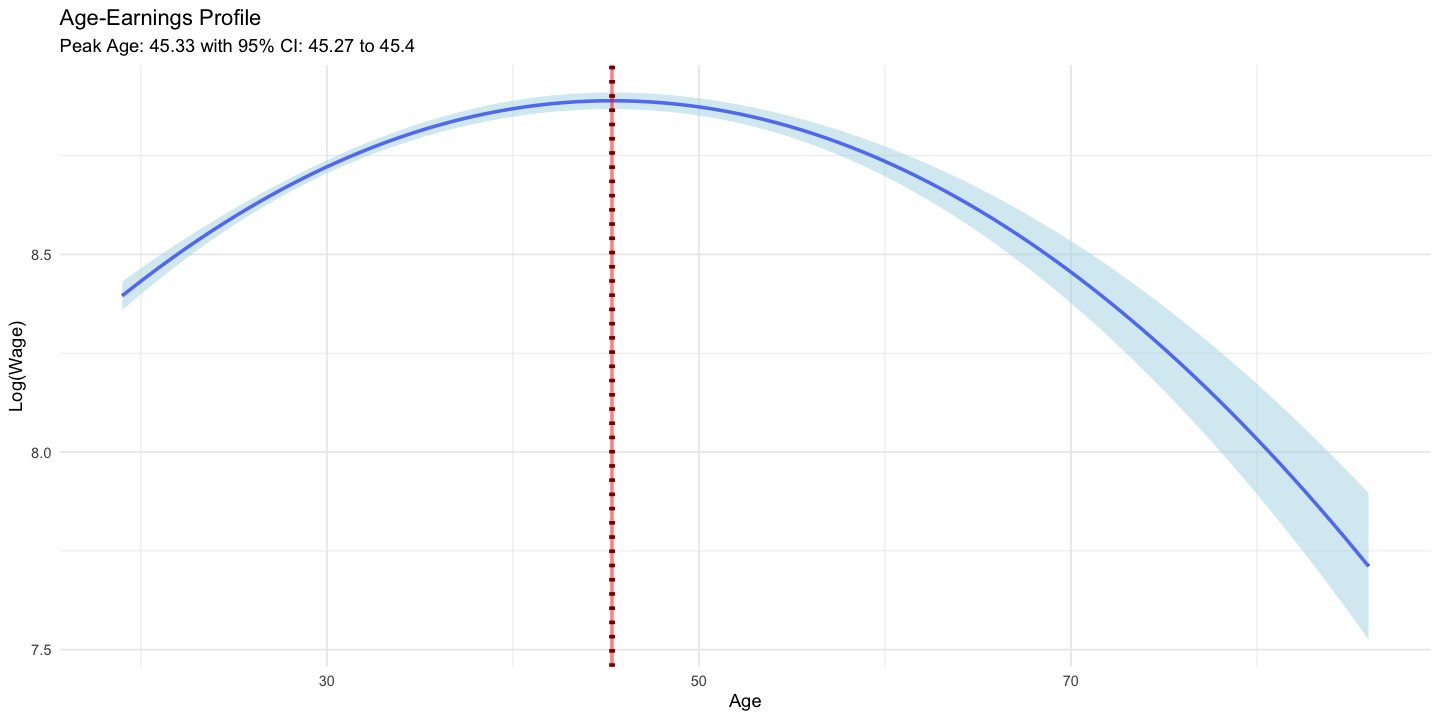

In [18]:
df_plot <- data.frame(
  age = age_range,
  predicted_ln_w = predicted_values[, "fit"],
  lwr = predicted_values[, "lwr"],
  upr = predicted_values[, "upr"]
)

# Gráfico del perfil de ingresos por edad con intervalos de confianza
options(repr.plot.width = 12, repr.plot.height = 6)

ggplot(df_plot, aes(x = age, y = predicted_ln_w)) +
  geom_line(color = "blue", size = 1) +  # Curva de predicción
  geom_ribbon(aes(ymin = lwr, ymax = upr), fill = "lightblue", alpha = 0.5) +  # Intervalo de confianza
  geom_vline(xintercept = peak_age,  color = "red", size = 1, alpha=0.5) +  # Línea de la edad pico
  geom_vline(xintercept = peak_age_ci[1], linetype = "dotted", color = "darkred", size = 1) +  # CI inferior
  geom_vline(xintercept = peak_age_ci[2], linetype = "dotted", color = "darkred", size = 1) +  # CI superior
  labs(
    title = "Age-Earnings Profile",
    subtitle = paste("Peak Age:", round(peak_age, 2), "with 95% CI:", round(peak_age_ci[1], 2), "to", round(peak_age_ci[2], 2)),
    x = "Age",
    y = "Log(Wage)"
  ) +
  theme_minimal()

### Predicting Earnings

In [19]:
training_size <- floor(0.7 * nrow(df_geih))
training_index <- sample(seq_len(nrow(df_geih)), size = training_size)

training_set <- df_geih[training_index, ]
test_set <- df_geih[-training_index, ]

In [46]:
# Función para generar todas las combinaciones de variables con ajuste de tipo y estimar el modelo
modelo_iterativo <- function(data, variables, respuesta = "ln_w", max_polinomio = 2, tipo_variable) {
  
  resultados <- list()  # Lista para guardar los resultados
  rmse_values <- c()    # Para almacenar los RMSE de cada modelo
  modelos_str <- c()    # Para almacenar las fórmulas de cada modelo
  
  # Paso 1: Asegurarse de que las variables categóricas numéricas sean factores y preparar variables continuas
  for (var in variables) {
    if (tipo_variable[[var]] == "categorica") {
      data[[var]] <- as.factor(data[[var]])
    }
  }
  
  # Paso 2: Generar todas las combinaciones posibles de variables
  for (num_var in 1:length(variables)) {
    combinaciones <- combn(variables, num_var, simplify = FALSE)
    
    for (comb in combinaciones) {
      # Crear la fórmula base con las variables categóricas y dicotómicas tal cual, 
      # y agregar los polinomios para las variables continuas
      formula_base <- ""
      for (var in comb) {
        if (tipo_variable[[var]] == "continua") {
          # Agregar polinomios para variables continuas
          for (p in 1:max_polinomio) {
            formula_base <- paste(formula_base, "+", var, "+ I(", var, "^", p, ")", sep = "")
          }
        } else {
          # Agregar variables categóricas y dicotómicas tal cual
          formula_base <- paste(formula_base, "+", var, sep = "")
        }
      }
      
      # Limpiar la fórmula final quitando el primer '+'
      formula_base <- sub("^\\+ ", "", formula_base)
      formula_final <- paste(respuesta, "~", formula_base)
      
      # Paso 3: Estimar el modelo
      modelo <- tryCatch({
        lm(as.formula(formula_final), data = data)
      }, error = function(e) return(NULL))  # Manejar errores de modelo
      
      # Si el modelo se estima correctamente
      if (!is.null(modelo)) {
        predicciones <- tryCatch({
          predict(modelo, newdata = data)
        }, error = function(e) return(NA))  # Manejar errores en las predicciones

        # Verificar si alguna predicción es NA
        if (!any(is.na(predicciones))) {
          rmse <- sqrt(mean((data[[respuesta]] - predicciones)^2))
        } else {
          rmse <- NA
        }
        
        # Guardar el RMSE y la fórmula del modelo correspondiente
        rmse_values <- c(rmse_values, rmse)
        modelos_str <- c(modelos_str, formula_final)
      } else {
        # Guardar el modelo con RMSE NA si no se puede estimar
        rmse_values <- c(rmse_values, NA)
        modelos_str <- c(modelos_str, formula_final)
      }
    }
  }
  
  # Paso 4: Guardar los modelos y RMSEs en un data frame
  resultados_df <- data.frame(modelos = modelos_str, rmse = rmse_values, stringsAsFactors = FALSE)
  
  return(resultados_df)
}

In [67]:
modelo_iterativo <- function(data, variables, respuesta = "y", max_polinomio = 2, tipo_variable) {
  
  # Vector para almacenar todas las posibles transformaciones de las variables
  todas_las_variables <- c()

  # Paso 1: Generar el vector con las transformaciones polinomiales para variables continuas
  for (var in variables) {
    if (tipo_variable[[var]] == "continua") {
      # Agregar la variable original
      todas_las_variables <- c(todas_las_variables, var)
      # Agregar los polinomios hasta el grado máximo
      for (grado in 2:max_polinomio) {
        polinomio_var <- paste("I(", var, "^", grado, ")", sep = "")
        todas_las_variables <- c(todas_las_variables, polinomio_var)
      }
    } else if (tipo_variable[[var]] %in% c("categorica", "dicotoma")) {
      # Asegurarse de que las categóricas y dicotómicas sean factores (texto)
      if (!is.factor(data[[var]])) {
        data[[var]] <- as.factor(data[[var]])
      }
      # Añadir la variable categórica o dicotómica
      todas_las_variables <- c(todas_las_variables, var)
    }
  }

  # Paso 2: Crear un dataframe para almacenar los resultados
  resultados <- data.frame(modelos = character(), rmse = numeric(), stringsAsFactors = FALSE)
  
  # Paso 3: Iterar sobre todas las combinaciones de las posibles variables
  for (num_var in 1:length(todas_las_variables)) {
    combinaciones <- combn(todas_las_variables, num_var, simplify = FALSE)
    
    for (comb in combinaciones) {
      # Paso 4: Crear la fórmula de regresión con la combinación de variables
      formula <- paste(respuesta, "~", paste(comb, collapse = " + "))
      
      # Paso 5: Ajustar el modelo de regresión lineal y calcular el RMSE
      modelo <- tryCatch({
        lm(as.formula(formula), data = data)
      }, error = function(e) return(NULL))  # Manejo de errores en caso de que falle el ajuste del modelo
      
      if (!is.null(modelo)) {
        predicciones <- tryCatch({
          predict(modelo, newdata = data)
        }, error = function(e) return(NA))  # Manejo de errores en las predicciones
        
        if (!any(is.na(predicciones))) {
          # Calcular RMSE si no hay NAs
          rmse <- sqrt(mean((data[[respuesta]] - predicciones)^2))
        } else {
          rmse <- NA
        }
        
        # Guardar el modelo y el RMSE en el dataframe
        resultados <- rbind(resultados, data.frame(modelos = formula, rmse = rmse))
      } else {
        # Si no se pudo ajustar el modelo, guardar el RMSE como NA
        resultados <- rbind(resultados, data.frame(modelos = formula, rmse = NA))
      }
    }
  }

  # Paso 6: Retornar el dataframe con los resultados
  return(resultados)
}

In [68]:
tipo_variable <- list(
  "maxEducLevel" = "categorica",
  "hoursWorkUsual" = "continua",
  "sex" = "dicotoma",
  "age" = "continua",
  "formal" = "dicotoma",
  "sizeFirm" = "categorica",
  "cotPension" = "categorica",
  "depto" = "categorica",
  "desoc" = "dicotoma",
  "extra_h" = "dicotoma",
  "bonif" = "dicotoma",
  "estrato1" = "categorica"
)

# Llamada a la función
resultados_modelos <- modelo_iterativo(data = training_set, 
                                       variables = c("maxEducLevel",
                                        "hoursWorkUsual",
                                        "sex",
                                        "age",
                                        "formal",
                                        "sizeFirm",
                                        "cotPension",
                                        "depto",
                                        "desoc",
                                        "extra_h",
                                        "bonif",
                                        "estrato1"), 
                                       respuesta = "ln_w", 
                                       max_polinomio = 3,
                                       tipo_variable = tipo_variable)

# Visualizar los resultados
print(resultados_modelos)

                                                                                                                                        modelos
1                                                                                                                           ln_w ~ maxEducLevel
2                                                                                                                         ln_w ~ hoursWorkUsual
3                                                                                                                    ln_w ~ I(hoursWorkUsual^2)
4                                                                                                                    ln_w ~ I(hoursWorkUsual^3)
5                                                                                                                                    ln_w ~ sex
6                                                                                                                                    ln_

In [69]:
mejores_modelos <- resultados_modelos[order(resultados_modelos$rmse), ][1:5, ]

In [76]:
min(mejores_modelos$rmse)

[1] 0.515387